## Forecasting

Forecasting is a statistical process used to predict future values based on previously observed values.

### Types of Forecasting

1. **Qualitative Forecasting**: 
    - Decisions are dependent upon expert opinions.
    - There is no data available to study patterns in order to make forecasting decisions.
    - Human decision-making is involved, which introduces a chance of bias.

2. **Quantitative Forecasting**: 
    - Decisions are based on statistical and mathematical models.
    - Relies on historical data to identify patterns and make predictions.
    - Minimizes human bias by using objective data.

### Time Series Forecast

Time series forecasting is the process of analyzing time series data using statistical methods and modeling to make predictions and informed strategic decisions, It falls under Quantitative Forecasting. The data used in this process is referred to as Time Series Data.

### Rules for Accurate Forecasting

To make accurate forecasts, follow these key rules:

1. **Granularity Rule**
    - **Explanation**: The more you aggregate your data, the more accurate your forecasts will be.
    - **Reason**: Aggregated data has less variation and noise.

2. **Frequency Rule**
    - **Explanation**: Update your data frequently to include new information.
    - **Reason**: This keeps your forecasts accurate and up-to-date.

3. **Horizon Rule**
    - **Explanation**: Avoid making long-term predictions.
    - **Reason**: Short-term predictions are more accurate than long-term ones.



### Let's Dive Deep

In [6]:
## Imports 
import warnings 
warnings.filterwarnings('ignore')

import zipfile
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Evaluate performance
from sklearn.metrics import mean_squared_error


sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline


### Constants 
DATA_FOLDER = "../data/"
ZIP_PATH = f'{DATA_FOLDER}/archive.zip'
csv_files = []
FIG_PATH = "../figures/"
ORG_DATA = pd.DataFrame()
COMMON_COMPANIES = ['AAPL', 'GOOG', 'MSFT', 'AMZN']


In [9]:
def save_figs(figname):
    plt.savefig(os.path.join(FIG_PATH, figname), format="png", dpi=300)

In [7]:
# ## Loading Data (Caution Run this Cell only Once)
# with zipfile.ZipFile(file=ZIP_PATH, mode="r") as zip_file:
#     zip_file.extractall(path="../data/")

# print("Files unzipped successfully!")


Files unzipped successfully!


In [8]:
csv_files = [f for f in os.listdir(DATA_FOLDER) if f.endswith('.csv')]

In [10]:
dfs = []

for file in csv_files:
    col_name = file.split(".")[0].strip()
    df = pd.read_csv(f'{DATA_FOLDER}{file}')
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce', utc=True)
    df['Date'] = pd.to_datetime(df['Date']).dt.date
    df = df.drop(columns=["Dividends", "Stock Splits"], axis=1)
    df["Company"] = col_name
    dfs.append(df)  

ORG_DATA = pd.concat(dfs, ignore_index=True)

data = ORG_DATA
data.set_index("Date", inplace=True)

   

#### Data Analysis

In [11]:
data.sample(10)

,Open,High,Low,Close,Volume,Company
Date,,,,,,
2023-05-24,301.820007,302.309998,298.329987,301.559998,842700,BIIB
2018-08-03,31.166155,31.603232,30.978838,31.585392,16485800,CMCSA
1986-07-18,0.357489,0.363194,0.357489,0.359391,5496000,AMGN
2015-10-09,14.492246,14.548701,14.121271,14.129336,9482600,GLW
2023-03-31,65.080002,66.000000,64.510002,65.709999,1069900,CTLT
1981-03-06,2.076044,2.083512,2.061108,2.076044,1078650,BA
2003-12-03,15.555638,15.713653,15.421033,15.485409,3832600,MCD
2017-02-22,16.059630,16.467028,14.796697,14.951509,14828000,HST
2014-10-29,27.424706,27.633633,27.274118,27.391296,35410955,GOOG


In [12]:
# Shape
print(f'Dataset (row,col): {data.shape}')

# Missing values
print(f'Missing values in Dataset:\n{data.isnull().sum()}')

# Duplicates
print(f'Duplicates in Dataset: {data.duplicated().sum()}')

Dataset (row,col): (4208047, 6)
Missing values in Dataset:
Open       0
High       0
Low        0
Close      0
Volume     0
Company    0
dtype: int64
Duplicates in Dataset: 17154


In [13]:
## Remove 17154 duplicates
data = data.drop_duplicates()

In [14]:
# check column types
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4190893 entries, 2014-09-22 to 2023-09-21
Data columns (total 6 columns):
 #   Column   Dtype  
---  ------   -----  
 0   Open     float64
 1   High     float64
 2   Low      float64
 3   Close    float64
 4   Volume   int64  
 5   Company  object 
dtypes: float64(4), int64(1), object(1)
memory usage: 223.8+ MB


In [15]:
## Popular Companies
pop_comps =  data[data['Company'].isin(COMMON_COMPANIES)]
pop_comps.sample(10)

,Open,High,Low,Close,Volume,Company
Date,,,,,,
1998-08-17,0.310720,0.324456,0.302195,0.317825,930876800,AAPL
2013-02-15,19.611490,19.757444,19.603271,19.748228,109601278,GOOG
2000-03-22,31.934695,32.808288,31.410539,32.070587,93975800,MSFT
2009-04-14,14.535175,14.617420,14.206189,14.467882,63796300,MSFT
2021-11-04,168.500000,174.931503,168.250000,173.850006,107060000,AMZN
2009-04-30,3.826253,3.849899,3.786846,3.814431,498489600,AAPL
2007-02-22,2.752526,2.752829,2.683713,2.713421,838224800,AAPL
2005-01-07,0.985210,1.055387,0.981421,1.049627,2227450400,AAPL
1994-01-10,0.243834,0.250299,0.241987,0.248452,201588800,AAPL


#### Limitations of Time Series Analysis?
Time series has the below-mentioned limitations; we have to take care of those during our data analysis.

1. Similar to other models, the missing values are not supported by TSA
2. The data points must be linear in their relationship.
3. Data transformations are mandatory, so they are a little expensive.
4. Models mostly work on Uni-variate data.

### Figures 

#### Closing Price
The closing price is the last price at which the stock is traded during the regular trading day. A stock’s closing price is the standard benchmark used by investors to track its performance over time.

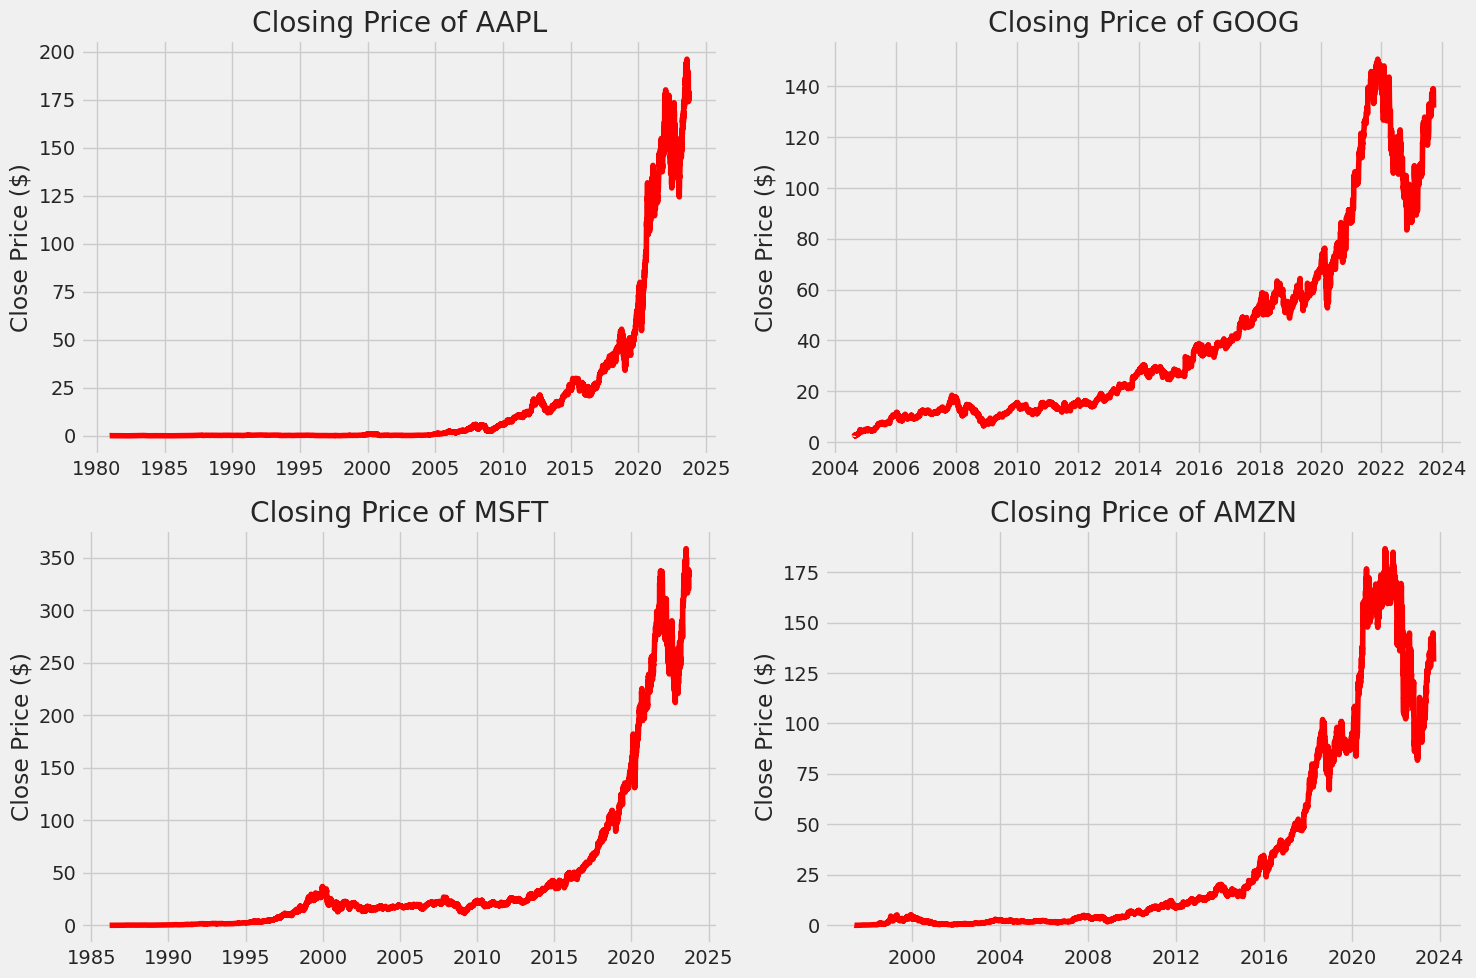

In [16]:
## Price Plot
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)
for i, company in enumerate(COMMON_COMPANIES, 1):
    plt.subplot(2, 2, i)
    pop_comps[pop_comps['Company'] == company]["Close"].plot(color='red', )
    plt.ylabel('Close Price ($)')
    plt.xlabel(None)
    plt.title(f"Closing Price of {COMMON_COMPANIES[i - 1]}")
plt.tight_layout()
save_figs("fig_1a.png")


#### Observations:

1. **Stock Prices Over Time:** The graph presents the closing prices of four major technology companies (Apple, Google, Microsoft, and Amazon) from approximately 1980 to 2024.

2. **Exponential Growth:** All four stocks exhibit significant growth over time, particularly in the later years. This suggests a strong upward trend in their stock values.

3. **Relative Performance:** While all stocks have grown, their performance varies. Apple and Microsoft have seen more substantial growth compared to Google and Amazon, especially in the earlier years.

4. **Market Fluctuations:** The lines are not perfectly smooth, indicating fluctuations in stock prices due to market conditions, company performance, and other factors.

5. **Recent Volatility:** The most recent years show increased volatility in all stock prices, with more pronounced ups and downs.

### Volume of Sales
Volume is the amount of an asset or security that changes hands over some period of time, often over the course of a day. For instance, the stock trading volume would refer to the number of shares of security traded between its daily open and close. Trading volume, and changes to volume over the course of time, are important inputs for technical traders.

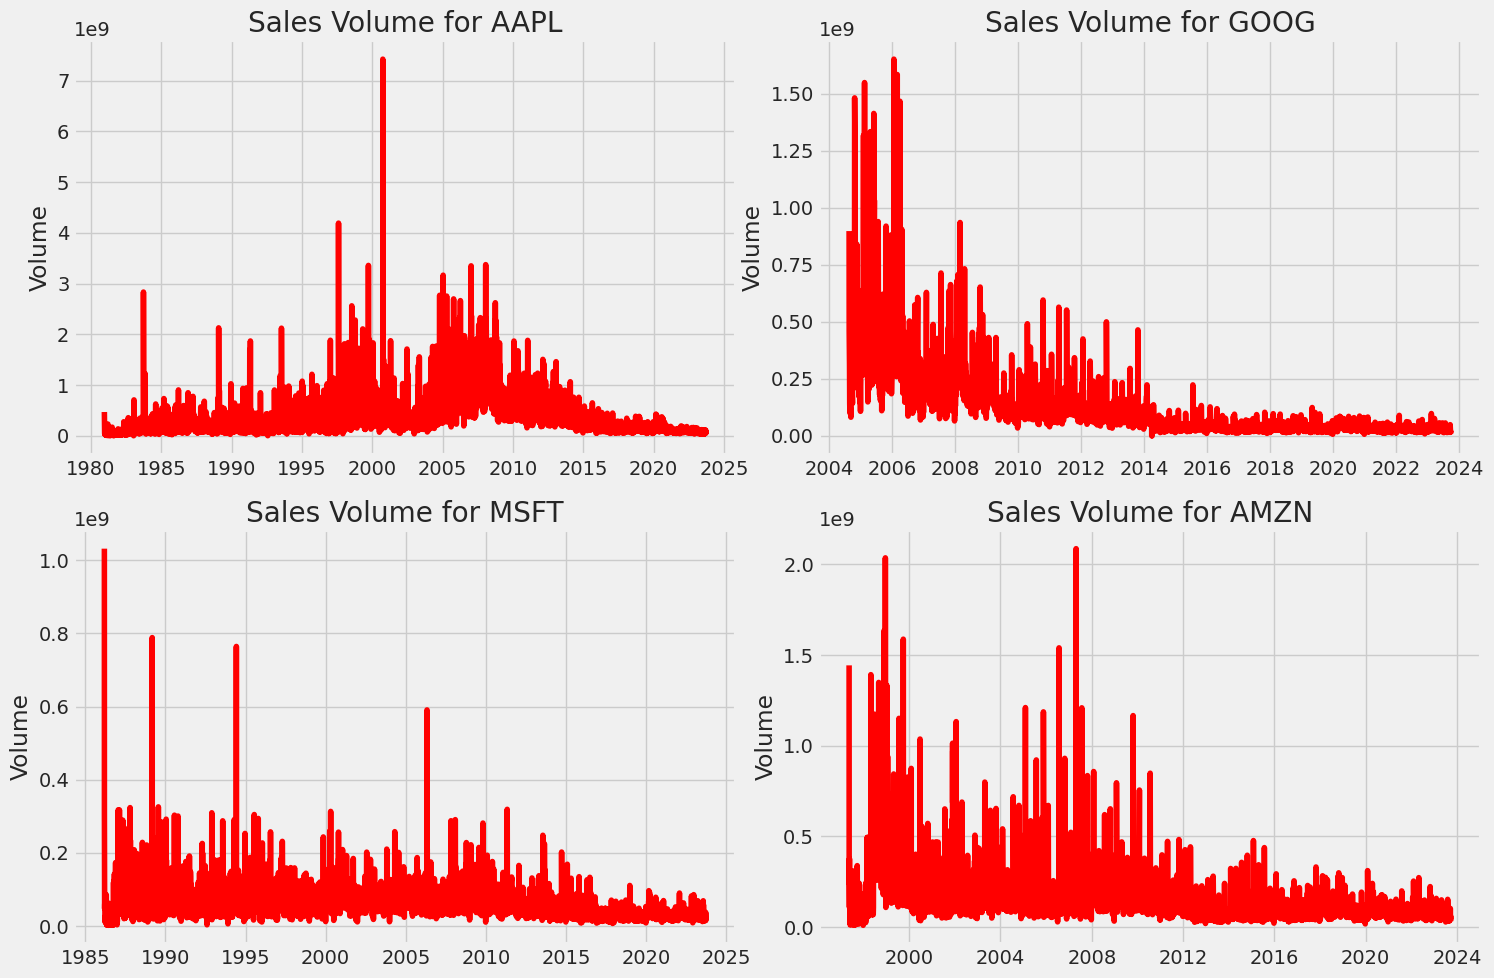

In [21]:
# Volume Plot
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(COMMON_COMPANIES, 1):
    plt.subplot(2, 2, i)
    pop_comps[pop_comps['Company'] == company]['Volume'].plot(color='red')
    plt.ylabel('Volume')
    plt.xlabel(None)
    plt.title(f"Sales Volume for {COMMON_COMPANIES[i - 1]}")
plt.tight_layout()
save_figs("fig_1b.png")

#### Observations:

1. **Sales Volume Over Time:** The image presents the sales volume for four
major technology companies (Apple, Google, Microsoft, and Amazon) from
approximately 1980 to 2024.

2. **Fluctuations:** All four companies exhibit significant fluctuations in
sales volume over time. There are periods of high sales volume
interspersed with periods of lower sales volume.

3. **Relative Performance:** While all companies have experienced
fluctuations, their sales volume patterns differ. Apple and Microsoft
demonstrate higher overall sales volume compared to Google and Amazon,
particularly in the earlier years.

4. **Recent Trends:** In recent years, all companies have exhibited
increasing sales volume, with Amazon and Google showing particularly
strong growth.

5. **Seasonality:** There appears to be some seasonality in the sales volume
data, with peaks and troughs occurring at regular intervals. This
could be attributed to factors such as product launches, holiday
seasons, or economic cycles.

### What was the moving average of the various stocks?
The moving average (MA) is a simple technical analysis tool that smooths out price data by creating a constantly updated average price. The average is taken over a specific period of time, like 10 days, 20 minutes, 30 weeks, or any time period the trader chooses.

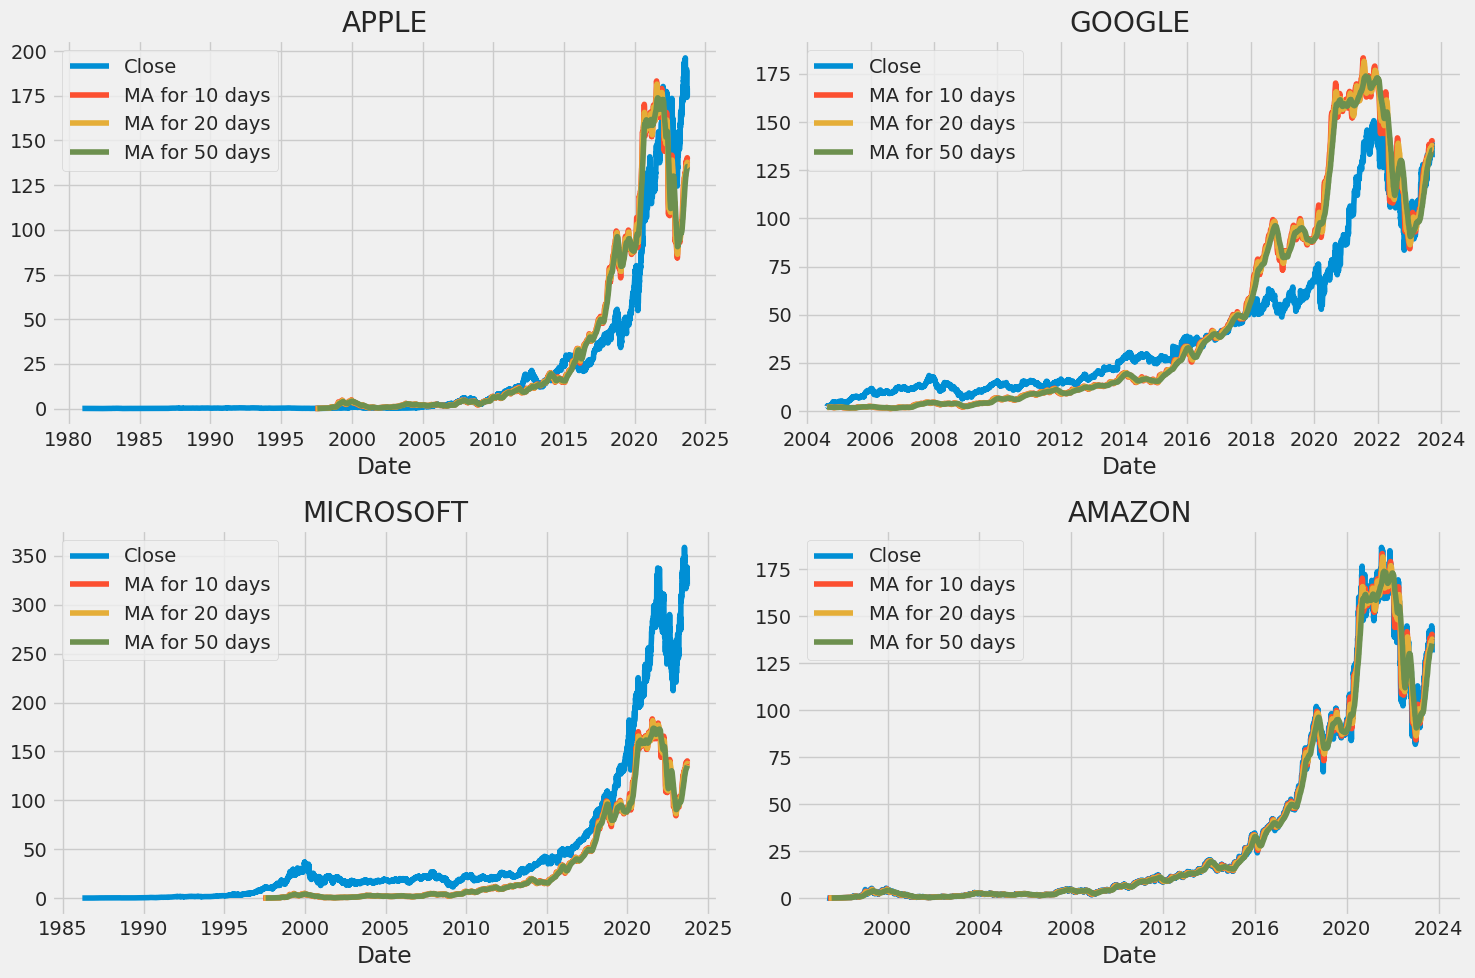

In [17]:
#Moving Averages Plot  
ma_day = [10, 20, 50]
for ma in ma_day:
    for company in COMMON_COMPANIES:
        column_name = f"MA for {ma} days"
        pop_comps[column_name] = pop_comps[pop_comps['Company'] == company]["Close"].rolling(ma).mean()


fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(15)
pop_comps[pop_comps['Company'] == "AAPL"][['Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0,0])
axes[0,0].set_title('APPLE')
pop_comps[pop_comps['Company'] == "GOOG"][['Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0,1])
axes[0,1].set_title('GOOGLE')
pop_comps[pop_comps['Company'] == "MSFT"][['Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1,0])
axes[1,0].set_title('MICROSOFT')
pop_comps[pop_comps['Company'] == "AMZN"][['Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1,1])
axes[1,1].set_title('AMAZON')
fig.tight_layout()
save_figs("fig_1c.png")

#### Observations 

1. **Overall Trend:**
All four companies (Apple, Google, Microsoft, and Amazon) exhibit strong upward trends in their stock prices over the analyzed period.
The rate of growth has accelerated in recent years, especially for Apple, Google, and Amazon.

2. **Relative Performance:**
Apple has consistently outperformed the other three companies in terms of stock price growth.
Microsoft has shown steady growth, though it trails Apple.
Google and Amazon have experienced significant growth in recent years, catching up with Apple and Microsoft.

3. **Volatility:**
All stocks exhibit periods of high volatility, especially during market downturns.
The volatility appears to have increased in recent years.

4. **Moving Averages:**
The relationship between the 10-day, 20-day, and 50-day moving averages provides insights into short-term and long-term trends.
When the shorter-term moving averages are above the longer-term ones, it generally indicates an uptrend.
Crossovers of moving averages can signal potential trend changes.

### Daily return of the stocks on average?

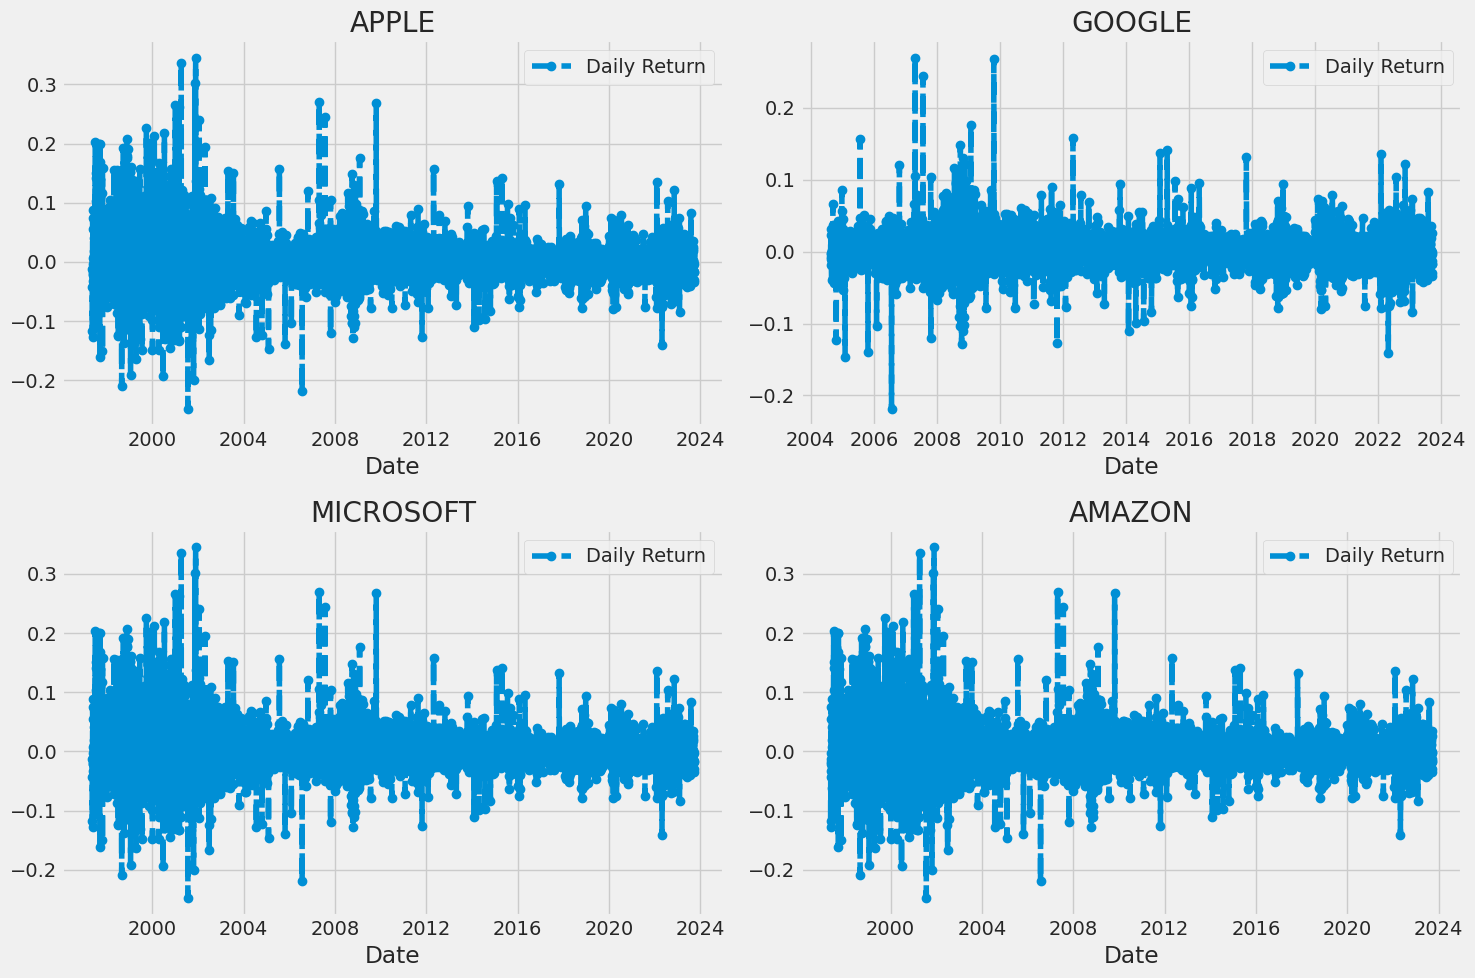

In [18]:
# We'll use pct_change to find the percent change for each day
for company in COMMON_COMPANIES:
    pop_comps['Daily Return'] = pop_comps[pop_comps['Company'] == company]['Close'].pct_change()
# Then we'll plot the daily return percentage
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(15)
pop_comps[pop_comps['Company'] == "AAPL"]['Daily Return'].plot(ax=axes[0,0], legend=True, linestyle='--', marker='o')
axes[0,0].set_title('APPLE')
pop_comps[pop_comps['Company'] == "GOOG"]['Daily Return'].plot(ax=axes[0,1], legend=True, linestyle='--', marker='o')
axes[0,1].set_title('GOOGLE')
pop_comps[pop_comps['Company'] == "MSFT"]['Daily Return'].plot(ax=axes[1,0], legend=True, linestyle='--', marker='o')
axes[1,0].set_title('MICROSOFT')
pop_comps[pop_comps['Company'] == "AMZN"]['Daily Return'].plot(ax=axes[1,1], legend=True, linestyle='--', marker='o')
axes[1,1].set_title('AMAZON')
fig.tight_layout()
save_figs("fig_1d.png")

#### Observations:

1. **High Volatility:** All four companies (Apple, Google, Microsoft, and Amazon) exhibit high levels of daily return volatility. This indicates significant price fluctuations on a day-to-day basis.
2. **No Consistent Patterns:** There are no apparent consistent patterns or trends in the daily returns. The data points appear to be randomly distributed around zero, suggesting that predicting future returns based solely on past returns might be challenging.
3. **Zero Mean:** The daily returns for all companies seem to fluctuate around zero, indicating that there is no consistent upward or downward bias in the short term.
4. **Similar Volatility:** While there are some variations, the overall volatility of daily returns appears relatively similar across the four companies.

### Model Training

#### Auto Regressive methods
In autoregressive methods, regression technique is used for forecasting the the future observations, using a linear combination of past observations. But for this the time series should follow 2 assumptions : Stationarity and Autocorrelation.




#### Components of a Time Series Data

1. **Level**
    - **Explanation**: The baseline of any time series.
    - **Detail**: This is the base value to which other components are added to form the complete time series.

2. **Trend**
    - **Explanation**: Indicates whether the time series increases or decreases over a period.
    - **Detail**: A trend can be upward (increasing) or downward (decreasing).

3. **Seasonality**
    - **Explanation**: A repeating pattern over a specific period.
    - **Detail**: This periodic pattern is called seasonality.

4. **Cyclicity**
    - **Explanation**: A pattern that repeats aperiodically (not at fixed intervals).
    - **Detail**: Unlike seasonality, cyclic patterns do not have a fixed period.

5. **Noise**
    - **Explanation**: Random fluctuations remaining after extracting level, trend, and seasonality/cyclicity.
    - **Detail**: Noise represents the random variability in the data.

#### Time Series Analysis: Stationarity Check

Time series analysis requires stationary data. Stationarity means that the statistical properties of a series, such as the mean and variance, are constant over time. A dataset should follow the below thumb rules without having Trend, Seasonality, Cyclical, and Irregularity components of the time series.

#### Components of a Time Series

1. **Level**: The average value in the series.
2. **Trend**: The increasing or decreasing value in the series.
3. **Seasonality**: The repeating short-term cycle in the series.
4. **Noise**: The random variation in the series.

#### Methods to check Stationarity 

1. Augmented Dickey-Fuller (ADF) Test
2. Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test


#### Augmented Dickey-Fuller (ADF) Test

The ADF test is used to determine the presence of a unit root in the series, which helps us understand if the series is stationary or not. The hypotheses for this test are:

- **Null Hypothesis (H0)**: The series has a unit root (i.e., the series is non-stationary).
- **Alternate Hypothesis (H1)**: The series does not have a unit root (i.e., the series is stationary).

#### Interpreting the Results

- If we **fail to reject** the null hypothesis, the series is **non-stationary**. This means the series might be linear or difference stationary.
- If the **mean and standard deviation** of the series are **constant** over time (i.e., flat lines), then the series is **stationary**.

In [19]:
AAPL = pop_comps[pop_comps["Company"] == "AAPL"]
AAPL = pd.DataFrame(AAPL).drop(columns=["Company", "Volume", "MA for 10 days", "MA for 20 days", "MA for 50 days", "Daily Return"])

AAPL.sample(10)

,Open,High,Low,Close
Date,,,,
1986-02-06,0.082154,0.083884,0.081722,0.083451
2019-10-31,60.116130,60.585406,57.689502,60.485714
2000-08-07,0.725645,0.743644,0.715225,0.726593
1985-04-10,0.072642,0.073506,0.072642,0.072642
1995-03-28,0.272368,0.273073,0.256402,0.258280
2013-04-17,12.928178,12.938330,12.246501,12.390773
2012-12-17,15.564793,15.903351,15.329301,15.867568
1984-12-12,0.091235,0.091235,0.088207,0.088207
2004-03-16,0.402420,0.403330,0.384838,0.391355


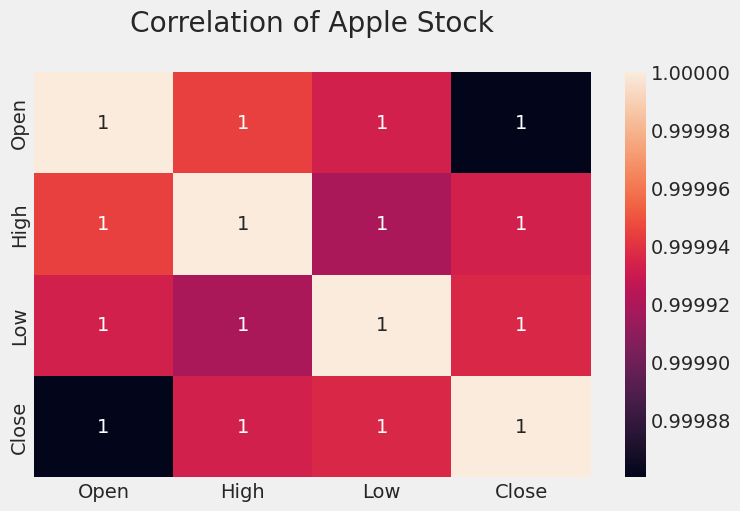

In [20]:
corr = AAPL.corr()
plt.figure(figsize=(8,5))
sns.heatmap(corr, annot=True)
plt.title("Correlation of Apple Stock\n")
save_figs("fig_1e.png")

In [22]:
AAPL = AAPL["Close"]
AAPL = pd.DataFrame(AAPL)
AAPL.sample(10)

,Close
Date,
1999-09-17,0.583074
2015-01-13,24.698112
2021-04-19,132.872726
1989-09-25,0.319620
2019-11-11,63.945045
1988-04-14,0.275180
2001-02-20,0.277564
2011-01-18,10.326516
1997-03-27,0.141151


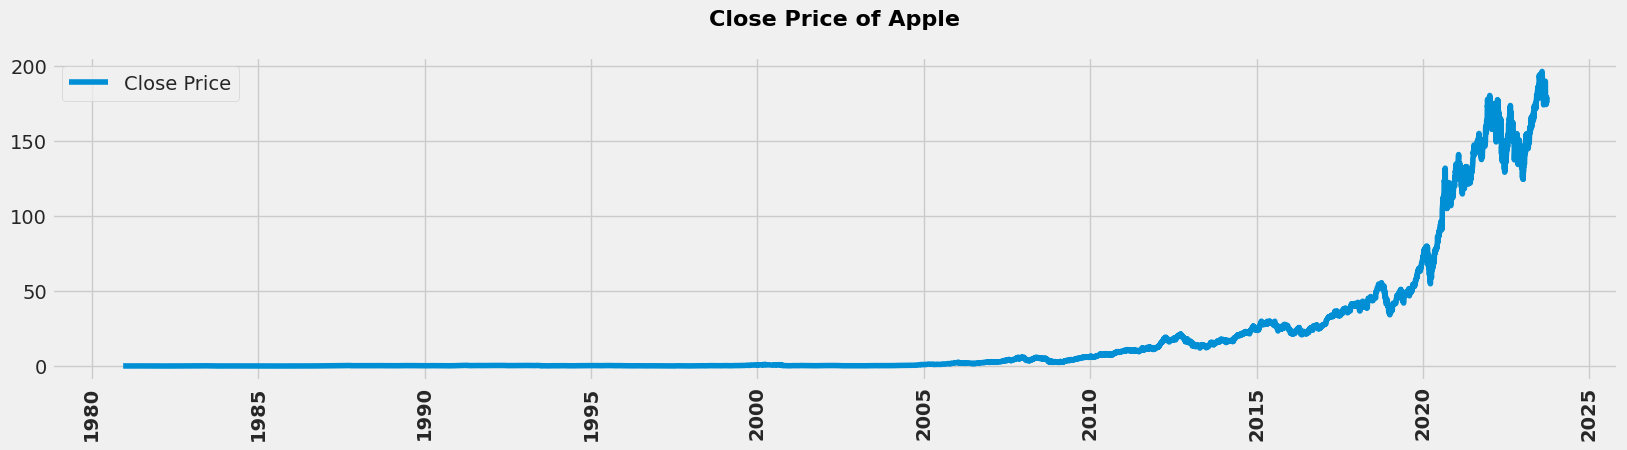

In [23]:
plt.figure(figsize=(18,4))
plt.plot(AAPL, label='Close Price')
plt.legend(loc='best')
plt.title('Close Price of Apple\n', fontdict={'fontsize': 16, 'fontweight' : 5, 'color' : 'black', "fontweight": "bold"})
plt.xticks(rotation = 90,fontweight="bold")
save_figs("fig_1f.png")
plt.show()

#### Augmented Dickey-Fuller (ADF) test

In [24]:
adf_test = adfuller(AAPL["Close"], autolag='AIC')

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' %adf_test[1])

ADF Statistic: 3.179396
Critical Values @ 0.05: -2.86
p-value: 1.000000


#### Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test

In [25]:
from statsmodels.tsa.stattools import kpss
kpss_test = kpss(AAPL['Close'])

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 8.158128
Critical Values @ 0.05: 0.46
p-value: 0.010000


#### Observations

1. **ADF Test:**
The null hypothesis of the ADF test is that the series has a unit root, meaning it is non-stationary.
The ADF statistic (3.179396) is much higher than the critical value (-2.86), which means you fail to reject the null hypothesis. This suggests that the series is non-stationary.
The p-value of 1.000000 also indicates that there is no evidence to reject the null hypothesis, further confirming that the series is non-stationary.


2. **KPSS Test:**
The null hypothesis of the KPSS test is that the series is stationary around a deterministic trend (or stationary in level, depending on the model).
The KPSS statistic (8.158128) is significantly higher than the critical value (0.46), meaning you reject the null hypothesis. This suggests that the series is non-stationary.
The low p-value (0.01) further supports rejecting the null hypothesis, indicating strong evidence that the series is non-stationary.

#### Decomposition for Finding Components of Time Series

Decomposition is one of the primary methods used to find and analyze the components of a time series. It systematically breaks down the time series into its underlying components, which typically include:

1. **Trend**: The long-term direction of the data (upward, downward, or flat).
2. **Seasonality**: Regular, repeating patterns or cycles in the data at fixed intervals.
3. **Cyclical**: Irregular cycles that don’t follow a fixed period (these are sometimes included in the trend component in simpler models).
4. **Irregularity (Noise/Residuals)**: The random variation in the data that isn’t explained by the trend or seasonality.

#### Types of Decomposition Models

There are two main types of decomposition models:

- **Additive Decomposition**: Assumes the components add together. It’s used when the seasonal variation is roughly constant over time.
  - **Model**: `Data = Trend + Seasonality + Irregularity`

- **Multiplicative Decomposition**: Assumes the components multiply together. It’s used when the seasonal variation increases or decreases with the level of the time series.
  - **Model**: `Data = Trend * Seasonality * Irregularity`

<Figure size 640x480 with 0 Axes>

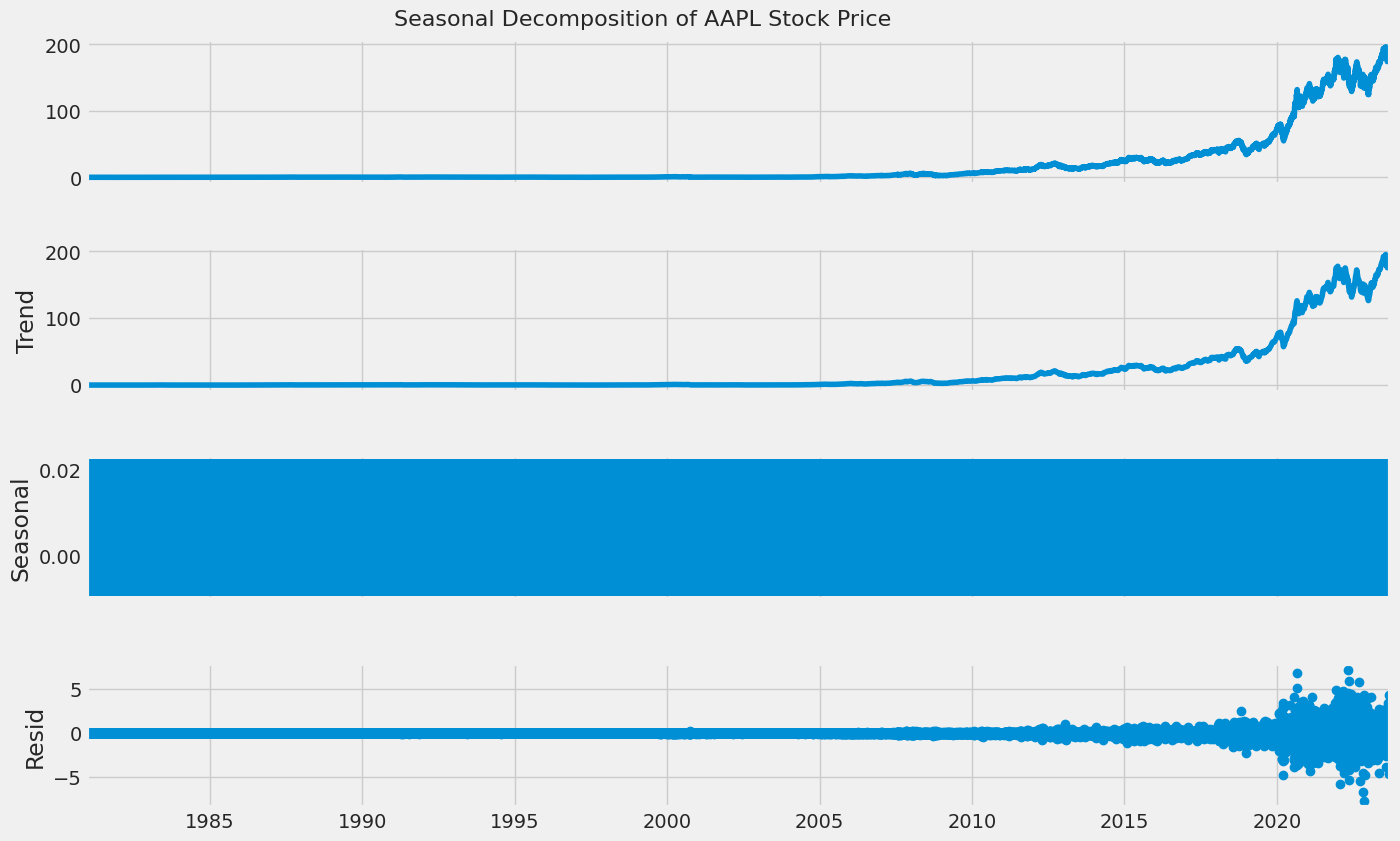

In [26]:
AAPL = AAPL.asfreq('D')
AAPL['Close'].interpolate(method='linear', inplace=True)  # Interpolate missing values
result = seasonal_decompose(AAPL, model='additive')
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)
fig.suptitle("Seasonal Decomposition of AAPL Stock Price\n", fontsize=16)
save_figs("fig_1g.png")


In [28]:
# Differencing to achieve stationarity if necessary
df_diff = np.log(AAPL).dropna()


In [29]:
adf_test = adfuller(df_diff)

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])


kpss_test = kpss(df_diff)

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

ADF Statistic: 0.434356
Critical Values @ 0.05: -2.86
p-value: 0.982735
KPSS Statistic: 19.005083
Critical Values @ 0.05: 0.46
p-value: 0.010000


In [27]:
##### Stationary point 

In [30]:
train_size = int(len(df_diff) * 0.8)
train, test = df_diff[:train_size], df_diff[train_size:]


In [31]:

# Fit ARIMA model
model = ARIMA(train, order=(5,1,0))  # Adjust (p,d,q) based on your analysis
model_fit = model.fit()

# Print model summary
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                12499
Model:                 ARIMA(5, 1, 0)   Log Likelihood               29182.505
Date:                Wed, 14 Aug 2024   AIC                         -58353.010
Time:                        21:44:31   BIC                         -58308.410
Sample:                    12-12-1980   HQIC                        -58338.079
                         - 03-02-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0676      0.006     11.761      0.000       0.056       0.079
ar.L2          0.0154      0.008      2.041      0.041       0.001       0.030
ar.L3         -0.0072      0.009     -0.762      0.4

In [32]:
# Forecast
forecast = model_fit.forecast(steps=len(test))



mse = mean_squared_error(test, forecast)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 1.0989332467956188


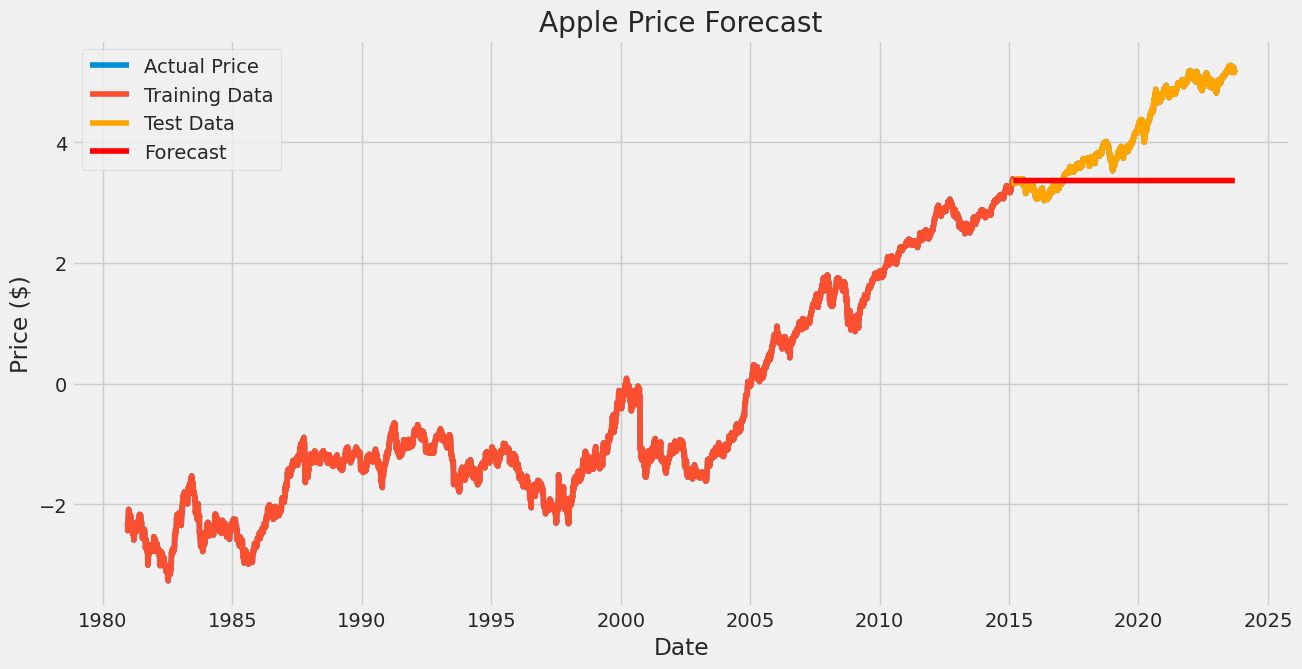

In [33]:
# Plot train, test, and forecast
plt.figure(figsize=(14,7))
plt.plot(df_diff, label='Actual Price')
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Test Data', color='orange')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.title('Apple Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
save_figs("fig_1h.png")
plt.show()


In [34]:
import itertools
import math

# Define the range of values for p, d, q, P, D, Q, and m
p_values = range(0, 3)  # Autoregressive order
d_values = [0]          # Differencing order
q_values = range(0, 3)  # Moving average order
P_values = range(0, 2)  # Seasonal autoregressive order
D_values = range(0, 1)  # Seasonal differencing order
Q_values = range(0, 2)  # Seasonal moving average order
m_values = [12]         # Seasonal period

# Create all possible combinations of SARIMA parameters
param_combinations = list(itertools.product(p_values, 
                                            d_values, 
                                            q_values, 
                                            P_values, 
                                            D_values, 
                                            Q_values, 
                                            m_values))

# Initialize AIC with a large value
best_aic = float("inf")  
best_params = None

# Perform grid search
for params in param_combinations:
    order = params[:3]
    seasonal_order = params[3:]
    
    try:
        model = SARIMAX(train, 
                               order=order, 
                               easonal_order=seasonal_order)
        result = model.fit(disp=False)
        aic = result.aic
        
        # Ensure the convergence of the model
        if not math.isinf(result.zvalues.mean()):
            print(order, seasonal_order, aic)
        
            if aic < best_aic:
                best_aic = aic
                best_params = params
                
        else:
            print(order, seasonal_order, 'not converged')

    except:
        continue

# Print the best parameters and AIC
print("Best Parameters:", best_params)
print("Best AIC:", best_aic)

(0, 0, 0) (0, 0, 0, 12) 49962.683608162595
(0, 0, 0) (0, 0, 1, 12) 49962.683608162595
(0, 0, 0) (1, 0, 0, 12) 49962.683608162595
(0, 0, 0) (1, 0, 1, 12) 49962.683608162595
(0, 0, 1) (0, 0, 0, 12) 32874.431153101454
(0, 0, 1) (0, 0, 1, 12) 32874.431153101454
(0, 0, 1) (1, 0, 0, 12) 32874.431153101454
(0, 0, 1) (1, 0, 1, 12) 32874.431153101454
(0, 0, 2) (0, 0, 0, 12) 17296.32136792056
(0, 0, 2) (0, 0, 1, 12) 17296.32136792056
(0, 0, 2) (1, 0, 0, 12) 17296.32136792056
(0, 0, 2) (1, 0, 1, 12) 17296.32136792056
(1, 0, 0) (0, 0, 0, 12) -58288.27815352172
(1, 0, 0) (0, 0, 1, 12) -58288.27815352172
(1, 0, 0) (1, 0, 0, 12) -58288.27815352172
(1, 0, 0) (1, 0, 1, 12) -58288.27815352172
(1, 0, 1) (0, 0, 0, 12) -58343.78875635497
(1, 0, 1) (0, 0, 1, 12) -58343.78875635497
(1, 0, 1) (1, 0, 0, 12) -58343.78875635497
(1, 0, 1) (1, 0, 1, 12) -58343.78875635497
(1, 0, 2) (0, 0, 0, 12) -58347.17556943149
(1, 0, 2) (0, 0, 1, 12) -58347.17556943149
(1, 0, 2) (1, 0, 0, 12) -58347.17556943149
(1, 0, 2) (1, 0

In [35]:
model = SARIMAX(train,
                       order=best_params[:3],
                       seasonal_order=best_params[3:])
result = model.fit(disp=False)

# Show the summary
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                12499
Model:               SARIMAX(1, 0, 2)   Log Likelihood               29177.588
Date:                Wed, 14 Aug 2024   AIC                         -58347.176
Time:                        21:46:39   BIC                         -58317.442
Sample:                    12-12-1980   HQIC                        -58337.222
                         - 03-02-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000   9.79e-05   1.02e+04      0.000       1.000       1.000
ma.L1          0.0678      0.006     11.829      0.000       0.057       0.079
ma.L2          0.0200      0.007      2.669      0.008       0.005       0.035
sigma2         0.0005   1.33e-06    413.637      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           4107483.47
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.53   Skew:                            -2.52
Prob(H) (two-sided):                  0.00   Kurtosis:                        91.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

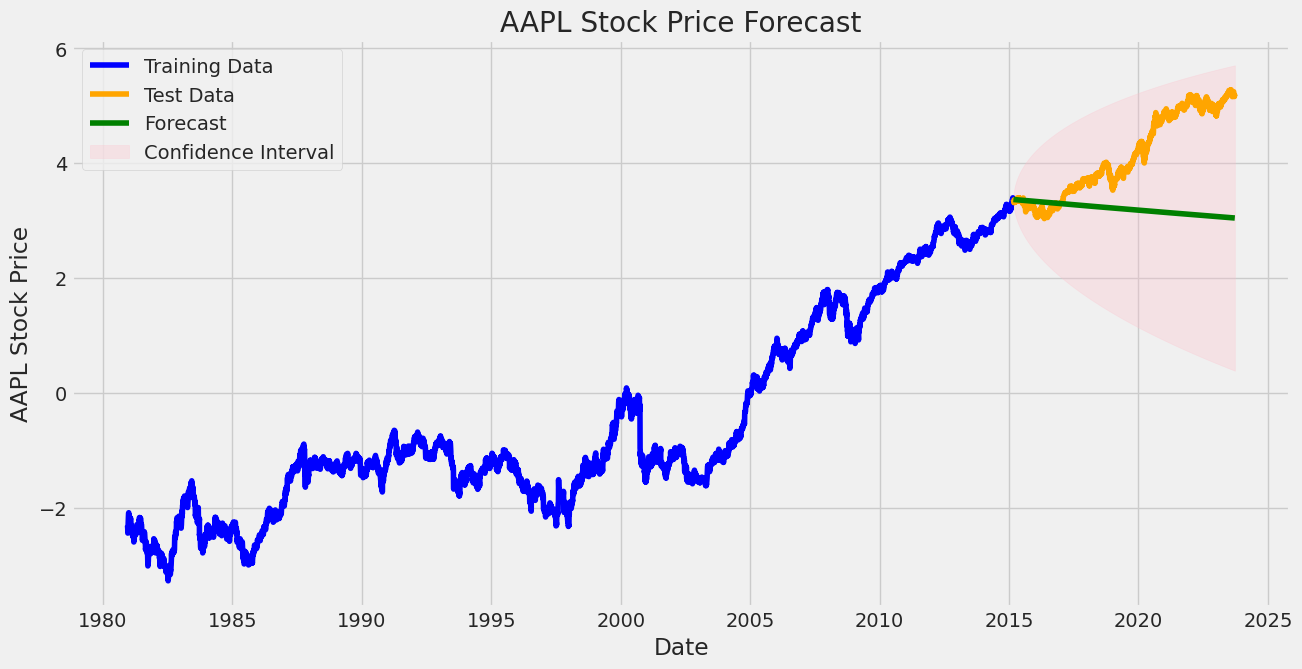

In [44]:
# Get forecast and confidence intervals for two years
forecast = result.get_forecast(steps=len(test))
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Plot the training data
plt.figure(figsize=(14, 7))
plt.plot(train.index, train['Close'], label='Training Data', color='blue')

# Plot the test data
plt.plot(test.index, test['Close'], label='Test Data', color='orange')

# Plot the forecasted values
# forecast_index = pd.date_range(start=test.index[-1], periods=24, freq='D')
plt.plot(test.index, forecast_values, label='Forecast', color='green')

#Plot the confidence intervals
plt.fill_between(test.index, 
                 confidence_intervals.iloc[:, 0], 
                 confidence_intervals.iloc[:, 1], 
                 color='pink', alpha=0.3, label='Confidence Interval')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('AAPL Stock Price')
plt.title('AAPL Stock Price Forecast')
plt.legend()

# Show the plot
plt.show()



In [45]:
# Predicted values and actual values
predicted_values = forecast_values.values
actual_values = test.values.flatten()

# Mean Absolute Error (MAE)
mae = np.mean(np.abs(predicted_values - actual_values))
print("MAE:", mae)

# Root Mean Squared Error (RMSE)
mse = np.mean((predicted_values - actual_values) ** 2)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((predicted_values - actual_values) / actual_values)) * 100
print("MAPE:", mape)

MAE: 0.9708230200388974
RMSE: 1.2303860374596125
MAPE: 21.031458188532763
